<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning với TensorFlow - Phần 1: Trích xuất đặc trưng

Chúng ta đã tạo khá nhiều CNN từ đầu và chúng có vẻ đều đang học, tuy nhiên vẫn còn không gian để cải thiện.

Để cải thiện mô hình, hãy dành một chút thời gian thử các cấu hình khác nhau, thêm nhiều lớp hơn, thay đổi tốc độ học, điều chỉnh số nơ-ron mỗi lớp,...

Tuy nhiên, thực hiện như vậy khá tốn thời gian.

May thay, có một kỹ thuật giúp tiết kiệm thời gian.

Đó là **transfer learning (học truyền tải)**, là lấy các pattern (còn gọi là trọng số) mà mô hình khác đã tìm hiểu từ một bài toán khác và sử dụng cho bài toán của bạn.

Có hai lợi ích chính khi sử dụng transfer learning:
1. Tận dụng kiến trúc mạng nơ-ron có sẵn được chứng minh là hoạt động tương tự với bài toán của chúng ta.
2. Tận dụng kiến trúc mạng nơ-ron đang hoạt động **vốn đã tìm hiểu** pattern trên dữ liệu tương tự với dữ liệu của chúng ta. Điều này đạt được kết quả tốt với ít dữ liệu tùy chỉnh hơn.

Như vậy, thay vì tạo thủ công hoặc xây dựng từ đầu kiến trúc mạng nơ-ron, chúng ta sẽ sử dụng những mô hình đã thực hiện cho các kiến trúc khác.

Và thay vì huấn luyện mô hình từ đầu với tập dữ liệu của chúng ta, có thể lấy các pattern mà mô hình đã tìm hiểu từ các tập dữ liệu như [ImageNet](http://www.image-net.org/) (có hàng triệu hình ảnh về các đối tượng khác nhau) và dùng chúng làm nền tảng cho mô hình của chúng ta. Điều này thường đạt được kết quả tốt với ít dữ liệu hơn.

Chúng ta sẽ thấy khả năng thực tế của transfer learning qua các notebook tiếp theo.

## Những điều chúng ta sẽ tìm hiểu

Chúng ta sẽ xem xét những điều sau với TensorFlow:

- Giới thiệu transfer learning (cách đánh bại tất cả các mô hình tự xây cũ của chúng ta)
- Sử dụng tập dữ liệu nhỏ hơn để tiến hành nhanh hơn (10% mẫu huấn luyện của 10 lớp thức ăn)
- Xây dựng mô hình trích xuất đặc trưng học truyền tải bằng TensorFlow Hub
- Giới thiệu TensorBoard callback để theo dõi kết quả huấn luyện mô hình
- So sánh kết quả mô hình với TensorBoard

## Cách sử dụng notebook này

Các bạn có thể đọc qua các mô tả và code (tất cả sẽ chạy, trừ những cell mắc lỗi có chủ đích), nhưng có một lựa chọn tốt hơn.

Tự viết toàn bộ code.

Nghiêm túc đấy. Hãy tạo notebook mới và tự viết lại từng dòng. Kiểm tra xem bạn có thể thay đổi nó không và lý do cho điều đó.

Bạn không cần viết mô tả bằng văn bản nhưng tự viết lại code là một cách tuyệt vời để có trải nghiệm thực tiễn.

Đừng lo lắng nếu mắc sai sót, ai cũng đều mắc lỗi cả. Cách thực hiện tốt hơn và mắc ít lỗi hơn là **viết nhiều code hơn**.

## Dùng GPU

Để bắt đầu, hãy kiểm tra xem, chúng ta có đang dùng GPU không. Sử dụng GPU giúp đảm bảo mô hình huấn luyện nhanh hơn so với chỉ sử dụng CPU.


In [1]:
# Chúng ta có đang sử dụng GPU không?
!nvidia-smi

Wed May  3 09:15:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060 S...  WDDM | 00000000:01:00.0  On |                  N/A |
| 24%   51C    P8               16W / 175W|   1283MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Transfer learning với TensorFlow Hub: Kết quả tốt chỉ với 10% dữ liệu

Nếu bạn đang nghĩ "chắc chắn ai đó khác dành thời gian tạo mô hình thích hợp cho việc..." thì bạn gặp may rồi.

Với nhiều bài toán cần sử dụng deep learning, rất có thể tồn tại một mô hình đang hoạt động.
 
Tin tốt là chúng ta có thể truy cập nhiều mô hình trong TensorFlow Hub.

[TensorFlow Hub](https://tfhub.dev/) là một kho lưu trữ các thành phần mô hình có sẵn, chúng ta có thể import và sử dụng một mô hình được huấn luyện đầy đủ với ít nhất một URL.

Bây giờ tôi thực sự muốn minh chứng khả năng của transfer learning với các bạn.

Sẽ thế nào nếu tôi nói rằng rằng chúng ta có thể đạt được kết quả tương tự (hoặc tốt hơn) so với mô hình tốt nhất của chúng ta cho tới nay chỉ với 10% dữ liệu ban đầu, hay ít hơn 10 lần dữ liệu.

Điều này có vẻ khác thường phải không?

Các bạn sẽ không nghĩ rằng nhiều ví dụ về ảnh thức ăn hơn sẽ dẫn tới kết quả tốt hơn chứ? 

Nghĩ vậy đúng rồi đấy, nhìn chung, nhiều dữ liệu hơn sẽ cho kết quả tốt hơn.

Tuy nhiên, sẽ thế nào nếu chúng ta không có nhiều dữ liệu? Sẽ thế nào nếu chúng ta chỉ có 75 ảnh mỗi lớp thay vì 750 hình mỗi lớp?

Thu thập thêm 675 ảnh của một lớp nhất định sẽ tốn nhiều thời gian.

Cho nên đây lại là một lợi ích chính của transfer learning.

**Transfer learning thường cho phép đạt được kết quả tốt hơn với ít dữ liệu hơn.**

Nhưng đừng chỉ nghe lời như vậy. Hãy download một tập con dữ liệu mà chúng ta đang sử dụng, cụ thể là 10% dữ liệu huấn luyện từ tập dữ liệu `10_food_classes` và sử dụng nó để huấn luyện một bộ phân loại hình ảnh thức ăn.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*Những gì chúng ta đang thực hiện cho việc xây dựng. Lấy một mô hình đã huấn luyện trước đó và thêm custom layer lên trên, trích xuất toàn bộ pattern cơ bản đã học trên một tập dữ liệu hình ảnh khác.* 



## Downloading và làm quen với dữ liệu

In [3]:
# Lấy dữ liệu (10% nhãn)
import zipfile

# Giải nén dữ liệu đã download 
zip_ref = zipfile.ZipFile("Data/10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [2]:
# Mỗi folder có bao nhiêu ảnh?
import os

# Xem quan 10% data directory và liệt kê số file
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Lưu ý mỗi training directory bây giờ có 75 ảnh chứ không phải 750 ảnh. Đây là then chốt cho việc chứng minh transfer learning hoạt động tốt thế nào với ít ảnh được dán nhãn hơn.

Test directory vẫn có cùng một lượng ảnh, có nghĩa là chúng ta sẽ huấn luyện trên ít dữ liệu hơn nhưng đánh giá mô hình trên cùng một lượng dữ liệu kiểm tra.

## Tạo data loader (chuẩn bị dữ liệu)

Chúng ta đã download dữ liệu, hãy dùng lớp  [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) với phương thức `flow_from_directory` để load ảnh.

In [3]:
# Thiết lập đầu vào dữ liệu
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Xuất sắc! Chúng ta thấy 750 ảnh trong tập huấn luyện thuộc về 10 lớp (75 ảnh mỗi lớp) và 2500 ảnh trong tập kiểm tra thuộc về 10 lớp (250 ảnh mỗi lớp).

## Thiết lập callback (những thứ chạy trong khi mô hình huấn luyện)

Trước khi xây dựng mô hình, chúng ta sẽ làm quen với một khái niệm quan trọng vì nó đóng vai trò chính trong các thử nghiệm xây dựng mô hình tương lai.

Đó là **callback**.

[Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) là chức năng bổ sung mà chúng ta có thể thêm vào mô hình để thực hiện trong khi hoặc sau khi huấn luyện. Một số callback phổ biến nhất gồm:
* [**Theo dõi thử nghiệm với TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - ghi lại chất lượng của nhiều mô hình rồi xem và so sánh các mô hình này theo cách trực quan trên [TensorBoard](https://www.tensorflow.org/tensorboard) (dashboard cho việc kiểm tra các tham số mạng nơ-ron). Hữu ích khi so sánh kết quả của các mô hình khác nhau trên dữ liệu.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - lưu mô hình khi nó huấn luyện do đó chúng ta có thể dừng huấn luyện nếu cần và quay lại để tiếp tục phần đang dang dở. Hữu ích nếu huấn luyện tốn nhiều thời gian và không thể hoàn thành trong một lần thực hiện.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - cho quá trình huấn luyện một khoảng thời gian bất kỳ và tự động ngừng huấn luyện khi nó không cải thiện nữa. Hữu ích khi có tập dữ liệu lớn và không biết quá trình huấn luyện kéo dài bao lâu.

Chúng ta sẽ khám phá từng thứ một nhưng trong notebook này, chúng ta sẽ xem cách sử dụng TensorBoard callback.

Có thể truy cập TensorBoard callback bằng [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). 

Chức năng chính của nó là lưu phép đo chất lượng huấn luyện mô hình vào `log_dir` đã chỉ định.

Theo mặc định, log được ghi lại mỗi epoch với tham số `update_freq='epoch'`, đây là một mặc định tốt vì việc theo dõi chất lượng mô hình quá thường xuyên có thể làm chậm quá trình huấn luyện mô hình.

Hãy tạo một hàm tạo ra TensorBoard callback để theo dõi thử nghiệm lập mô hình với TensorBoard.

> 🔑 **Lưu ý:** Chúng ta tạo một hàm để tạo TensorBoard callback vì như chúng ta sẽ thấy, mỗi mô hình cần TensorBoard callback instance riêng (để hàm sẽ tạo ra một instance mới mỗi lần nó chạy).



In [4]:
# Tạo tensorboard callback (được tạo hàm do cần tạo mới mỗi mô hình) 
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Do chúng ta có thể sẽ chạy nhiều thử nghiệm nên hãy theo dõi chúng theo một số cách.

Trong tường hợp này, các hàm sẽ lưu nhật ký chất lượng của mô hình vào một directory có tên `[dir_name]/[experiment_name]/[current_timestamp]`, trong đó:
* `dir_name` là directory nhật ký tổng quát
* `experiment_name` là experiment cụ thể
* `current_timestamp` là thời điểm experiment bắt đầu theo [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now) của Python

> 🔑 **Lưu ý:** Tùy thuộc vào từng trường hợp, phương pháp đặt tên theo theo dõi thử nghiệm có thể hoạt động hoặc bạn có thể yêu cầu một số thứ cụ thể hơn. Tin tốt là TensorBoard callback giúp bạn dễ dàng theo dõi log miễn là bạn chỉ định vị trí để theo dõi chúng. Do đó, bạn có thể sáng tạo tùy ý với cách đặt tên experiment, chỉ cần đảm bảo bạn hoặc team của bạn hiểu được.



## Tạo mô hình với TensorFlow Hub

Chúng ta đã từng dùng TensorFlow để tạo mô hình từng layer của riêng mình từ đầu.

Bây giờ chúng ta sẽ thực hiện quá trình tương tự, trừ việc phần lớn các layer của mô hình đến từ [TensorFlow Hub](https://tfhub.dev/).

Thực tế, chúng ta sẽ sử dụng 2 mô hình từ TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  kiến trúc mô hình thị giác máy tính state of the art (SOTA) từ 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - kiến trúc mô hình thị giác máy tính SOTA từ 2019.

State of the art (SOTA) nghĩa là ở một số thời điểm, cả hai mô hình này có tỷ lệ lỗi thấp nhất trên [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), tiêu chuẩn vàng của đánh giá xếp hạng máy tính.

Có thể các bạn đang thắc mắc làm thế nào để tìm các mô hình này trên TensorFlow Hub?

Here are the steps I took: Dưới đây là một số bước mà tôi thực hiện:

1. Tới [tfhub.dev](https://tfhub.dev/).
2. Chọn Problem domain, chẳng hạn "Image" (chúng ta đang sử dụng food image).
3. Chọn phiên bản TF, trong trường hợp này là TF2.
4. 
Loại bỏ tất cả các bộ lọc "Problem domain" trừ bài toán mà bạn đang giải quyết.
  * **Lưu ý:** "Image feature vector" có thể sử dụng cùng với hầu hết bất kỳ bài toán nào, chúng ta sẽ thấy điều này sau.
5. Các mô hình đã liệt kê là tất cả những mô hình có thể sử dụng cho bài toán của bạn.

> 🤔 **Câu hỏi:** *Tôi thấy nhiều lựa chọn cho các mô hình phân loại hình ảnh, làm thế nào để biết lựa chọn nào tốt nhất?* 

Chúng ta sẽ thấy danh sách các mô hình SOTA trên [paperswithcode.com](https://www.paperswithcode.com), đây là một nguồn thu thập các kết quả báo cáo mới nhất về deep learning, có triển khai code cho các phát hiện trong báo cáo.

Vì chúng ta đang hoạt động với ảnh nên mục tiêu của chúng ta là [mô hình hoạt động tốt nhất trên ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet). 

Có thể các bạn sẽ không tìm thấy tất cả kiến trúc mô hình đã liệt kê trong paperswithcode xuất hiện trên TensorFlow Hub. Không sao cả, chúng ta vẫn có thể dùng những thứ sẵn có.

Hãy thu hẹp tìm kiếm với tab Architecture để tìm mô hình.

6. Chọn tab Architecture trên TensorFlow Hub, bạn sẽ thấy menu thả xuống có các tên kiến trúc.
  * Quy tắc ở đây là tên có số lớn hơn là nhũng mô hình hoạt động tốt hơn, chẳng hạn: EfficientNetB4 hoạt động tốt hơn EfficientNetB0.
    * Tuy nhiên, đánh đổi với số lớn hơn nghĩa là chúng tốn nhiều thời gian hơn để tính.
7. Chọn EfficientNetB0 và bạn sẽ thấy [một số thứ như sau](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0&tf-version=tf2):
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png)
8. Chọn cái có tiêu đề "[efficientnet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)" sẽ đưa chúng ta tới trang có button "Copy URL". Chúng ta có thể dùng URL này để khai thác khả năng của EfficientNetB0.
  * Copy URL sẽ được: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

> 🤔 **Câu hỏi:** *Tôi nghĩ rằng chúng ta đang phân loại hình ảnh, tại sao chúng ta lại chọn feature vector mà không chọn classification?* 

Quan sát tốt đấy! Đây là lúc mà các loại transfer learning khác phát huy tác dụng, đó là feature extraction (trích xuất đặc trưng) và fine-tuning (tinh chỉnh).

1. **"As is" transfer learning** là khi bạn lấy pretrained model và áp dụng vào nhiệm vụ của mình mà không thay đổi bất kỳ điều gì.

  * Ví dụ: nhiều mô hình computer vision được huấn luyện trước trên tập dữ liệu ImageNet chứa 100 lớp ảnh khác nhau, tức là truyền một ảnh đơn giản vào mô hình này sẽ tạo ra 100 giá trị xác suất dự đoán (1 cho mỗi lớp).

    * Điều này hữu ích nếu có 100 lớp ảnh cần phân loại và chúng đều giống với lớp ImageNet; tuy nhiên, nếu chúng ta chỉ muốn phân loại một tập hợp con các lớp (chẳng hạn như 10 loại thức ăn khác nhau) thì nó lại không giúp ích gì. Mô hình có `"/classification"` trong tên trên TensorFlow Hub cung cấp loại chức năng này.

2. **Feature extraction transfer learning** là khi bạn lấy các pattern cơ bản (hay còn gọi là trọng số) mà pretrained model tìm hiểu được và điều chỉnh các đầu ra của nó để phù hợp hơn với bài toán.

  * Ví dụ: giả sử pretrained model mà chúng ta đang dùng có 236 layer khác nhau (EfficientNetB0 có 236 layer), nhưng layer trên cùng xuất 1000 lớp vì nó đã được huấn luyện trên ImageNet. Để điều chỉnh nó cho bài toán của bạn, có thể loại layer kích hoạt ban đầu và thay thế nó bằng layer của bạn nhưng với số lớp đầu ra thích hợp. Phần quan trọng ở đây là **chỉ những layer ở trên cùng mới có thể huấn luyện, những layer còn lại bị đóng băng**.

    * Theo cách này, tất cả các pattern cơ bản vẫn nằm ở các layer còn lại và có thể dùng chúng cho bài toán của riêng bạn. Loại transfer learning này rất hữu ích khi dữ liệu của bạn tương tự với dữ liệu mà mô hình đã được huấn luyện trước.

3. **Fine-tuning transfer learning** là khi bạn lấy các pattern cơ bản (còn gọi là trọng số) của pretrained model và điều chỉnh (fine-tune) chúng với bài toán của mình.

    * Điều này thường có nghĩa là huấn luyện **một số, nhiều hoặc toàn bộ** layer trong pretrained model. Nó hữu ích khi có tập dữ liệu lớn (chẳng hạn trên 100 ảnh mỗi lớp) trong đó dữ liệu của bạn khá khác so với dữ liệu mà mô hình ban đầu huấn luyện.

Quy trình phổ biến là "đóng băng" tất cả các pattern đã tìm hiểu ở các layer dưới cùng của pretrained model để chúng có thể huấn luyện được, sau đó huấn luyện 2-3 layer trên cùng để pretrained model có thể điều chỉnh đầu ra của nó với dữ liệu tùy chỉnh của bạn (**feature extraction**).

Sau khi đã huấn luyện 2-3 layer trên cùng, chúng ta có thể dần "giải phóng" nhiều layer hơn và tiến hành quá trình huấn luyện trên dữ liệu của riêng bạn để **tinh chỉnh** thêm pretrained model.

> 🤔 **Câu hỏi:** *Tại sao chỉ huấn luyện 2-3 layer trong feature extraction?* 

Trong mô hình thị giác máy tính, layer càng thấp, càng gần với layer đầu vào thì các đặc trưng mà nó học được càng lớn. Ví dụ: layer dưới cùng trong mô hình thị giác máy tính xác định ảnh mèo và chó có thể học được đường nét của chân, trong đó các layer gần với đầu ra hơn sẽ học được shape của răng. Chúng ta thường muốn giữ nguyên các đặc trưng lớn hơn (các pattern học được cũng gọi là đặc trưng) vì các đặc trưng này của 2 loại động vật giống nhau, khác biệt nằm ở các đặc trưng chi tiết hơn.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)
*Các loại transfer learning khác nhau: mô hình ban đầu, mô hình feature extraction (chỉ thay đổi 2-3 layer trên cùng) và mô hình fine-tuning (thay đổi nhiều hoặc tất cả layer của mô hình ban đầu).* 

Hãy xem cách thực hiện điều này, giải thích những gì đang xảy ra.

Trước tiên, chúng ta sẽ import TensorFlow và TensorFlow Hub. 

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Chúng ta đã có các feature vector URL của 2 kiến trúc thị giác máy tính phổ biến nhất: [EfficientNetB0 (2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) và [ResNetV250 (2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4) từ TensorFlow Hub sử dụng các bước trên.

Chúng ta sẽ lấy cả hai để so sánh xem cái nào hoạt động tốt hơn trên dữ liệu của chúng ta.

> 🔑 **Lưu ý:** So sánh chất lượng kiến trúc mô hình khác nhau trên cùng một dữ liệu rất thường thấy, đơn giản là vì chúng ta muốn biết mô hình nào hoạt động tốt nhất cho bài toán. 

> **Cập nhật:** Kể từ 14/08/2021, [EfficientNet V2 pretrained models có trên TensorFlow Hub](https://tfhub.dev/google/collections/efficientnet_v2/1). Code ban đầu trong notebook này sử dụng EfficientNet V1, nó vẫn chưa thay đổi. Trong [các thử nghiệm của tôi với tập dữ liệu này](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/166), V1 hoạt động tốt hơn V2. Tốt nhất bạn hãy thử nghiệm với dữ liệu của mình và xem cái nào thích hợp với bạn nhất.

In [6]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Ban đầu: EfficientNetB0 feature vector (ver 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # Mới: EfficientNetB0 feature vector (ver 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

Các URL này liên kết với một pretrained model đã lưu trên TensorFlow Hub.

Khi sử dụng chúng trong mô hình của chúng ta, mô hình sẽ tự động download để chúng ta sử dụng.

Để thực hiện, hãy dùng mô hình [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) bên trong thư viện TensorFlow hub.

Do chúng ta sẽ so sánh 2 mô hình nên hãy tạo hàm `create_model()` để lưu code. Hàm này sẽ lấy một TensorFlow Hub URL của mô hình, khởi tạo mô hình tuần tự Keras với số lượng layer đầu ra thích hợp và trả về mô hình.

In [7]:
def create_model(model_url, num_classes=10):
  """Lấy TensorFlow Hub URL và tạo mô hình tuần tự Keras với nó.
  
  Đối số:
    model_url (str): TensorFlow Hub feature extraction URL.
    num_classes (int): Số nơ-ron đầu ra trong layer đầu ra,
       bằng số lớp mục tiêu, mặc định là 10.

  Trả về:
    Một mô hình tuần tự Keras chưa biên dịch với model_url là feature
    extractor layer và Dense output layer với đầu ra num_classes.
  """
  # Download pretrained model và lưu nó làm Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # đóng băng các pattern cơ bản
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # xác định shape ảnh đầu ra
  
  # Tạo mô hình của riêng bạn
  model = tf.keras.Sequential([
    feature_extractor_layer, # sử dụng feature extraction layer làm layer cơ bản
    layers.Dense(num_classes, activation='softmax', name='output_layer') # tạo layer đầu ra của bạn      
  ])

  return model

Tuyệt! Chúng ta đã có hàm tạo mô hình, hãy dùng nó để tạo mô hình sử dụng kiến trúc ResNetV250 làm feature extraction layer.

Sau khi khởi tạo mô hình, chúng ta sẽ biên dịch nó với hàm mất mát `categorical_crossentropy`, thuật toán tối ưu Adam và phép đo accuracy.

In [8]:
# Tạo mô hình
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Biên dịch
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)
*Mô hình hiện tại của chúng ta trông như vậy. ResNet50V2 là phần cơ bản nhất cùng với một dense layer tùy chỉnh ở trên cùng (10 lớp thay vì 100 lớp ImageNet). Hình hiển thị ResNet34 thay vì ResNet50. **Nguồn ảnh:** https://arxiv.org/abs/1512.03385.*  

Đến lúc khớp mô hình rồi.

Chúng ta đã sẵn sàng với dữ liệu huấn luyện trong `train_data_10_percent` và dữ liệu kiểm tra được lưu trong `test_data`.

Nhưng trước khi gọi hàm khớp, cần thêm callback, cụ thể là TensorBoard callback để theo dõi chất lượng mô hình trong TensorBoard.

Thêm callback vào mô hình với tham số `callbacks` trong hàm khớp.

Trong trường hợp này, chúng ta sẽ truyền tham số `callbacks` vào `create_tensorboard_callback()` vừa tạo với một số đầu vào cụ thể để biết chúng ta đang chạy experiment nào.

Hãy giữ experiment ngắn thôi và huấn luyện cho 5 epoch.

In [11]:
# Khớp mô hình
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Thêm TensorBoard callback vào mô hình (tham số callbacks lấy một danh sách)
                                  callbacks=[
                                      create_tensorboard_callback(dir_name='Model', # Lưu nhật ký experiment log ở đây
                                                                  experiment_name='resnet50V2') # Tên của file nhật ký
                                  ])

Saving TensorBoard log files to: Model/resnet50V2/20230503-091715
Epoch 1/5
24/24 [==============================] - 123s 5s/step - loss: 0.9720 - accuracy: 0.7200 - val_loss: 0.8801 - val_accuracy: 0.7260
Epoch 2/5
24/24 [==============================] - 122s 5s/step - loss: 0.6557 - accuracy: 0.8147 - val_loss: 0.7795 - val_accuracy: 0.7408
Epoch 3/5
24/24 [==============================] - 123s 5s/step - loss: 0.4937 - accuracy: 0.8640 - val_loss: 0.7203 - val_accuracy: 0.7676
Epoch 4/5
24/24 [==============================] - 121s 5s/step - loss: 0.3898 - accuracy: 0.9147 - val_loss: 0.6840 - val_accuracy: 0.7800
Epoch 5/5
24/24 [==============================] - 124s 5s/step - loss: 0.3206 - accuracy: 0.9347 - val_loss: 0.6706 - val_accuracy: 0.7804


Có vẻ sau 5 epoch, mô hình feature extraction ResNetV250 có thể đánh bại bất kỳ kiến trúc nào, đạt được độ chính xác 909% trên tập huấn luyện và gần 80% trên tập kiểm tra...**chỉ với 10% ảnh huấn luyện!**

Điều đó cho thấy khả năng của transfer learning. Đó là một trong các lý do chính mà chúng ta nên xem xét những pretrained model đã tồn tại bất cứ khi nào lập mô hình tập dữ liệu của riêng mình.

Hãy kiểm tra training curve của mô hình với hàm `plot_loss_curves`.

In [12]:
# Nếu muốn, bạn có thể biến nó thành hàm hỗ trợ để load với script helper.py
import matplotlib.pyplot as plt

# Vẽ biểu đồ dữ liệu huấn luyện và kiểm định một cách riêng biệt
def plot_loss_curves(history):
  """
  Trả về các loss curve riêng cho các phép đo huấn luyện và kiểm định.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Vẽ loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Vẽ accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

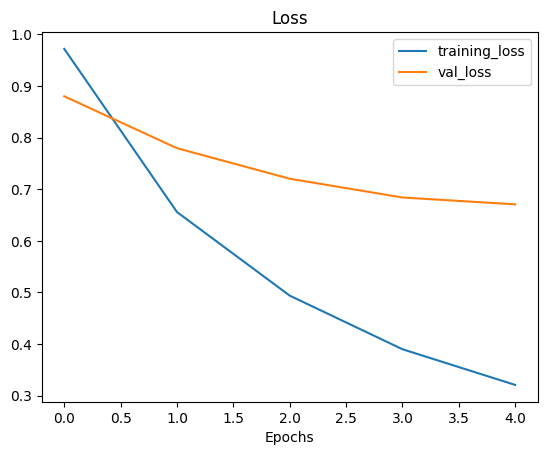

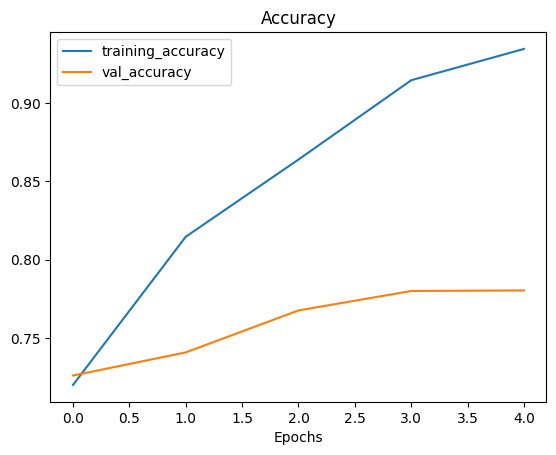

In [13]:
plot_loss_curves(resnet_history)

Vậy còn summary của mô hình?

In [14]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Các bạn có thể thấy khả năng của TensorFlow Hub ở đây. Feature extraction layer có 23,564,800 tham số là các pattern đã được tìm hiểu trước mà mô hình học trong tập dữ liệu ImageNet. Do chúng ta đã đặt `trainable=False` nên các pattern này vẫn đóng băng (không thể huấn luyện (trong quá trình huấn luyện).

Điều này có nghĩa là trong quá trình huấn luyện, mô hình cập nhật 20,490 tham số ở layer đầu ra để tương thích với tập dữ liệu của chúng ta.
Chúng ta đã huấn luyện mô hình ResNetV250, bây giờ hãy huấn luyện mô hình EfficientNetB0.

Thiết lập sẽ giống hệt trước, trừ tham số `model_url` trong hàm `create_model()` và tham số `experiment_name` trong hàm `create_tensorboard_callback()`. 

In [18]:
# Tạo mô hình
efficientnet_model = create_model(model_url=efficientnet_url, # sử dụng EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Biên dịch mô hình EfficientNet
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Khớp mô hình EfficientNet 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # chỉ dùng 10% dữ liệu huấn luyện
                                              epochs=5, # huấn luyện 5 epoch
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="Model", 
                                                                                     # Theo dõi nhật ký dưới các experiment name khác nhau
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: Model/efficientnetB0/20230503-094420
Epoch 1/5
24/24 [==============================] - 91s 4s/step - loss: 1.8906 - accuracy: 0.3853 - val_loss: 1.3711 - val_accuracy: 0.6736
Epoch 2/5
24/24 [==============================] - 81s 3s/step - loss: 1.1100 - accuracy: 0.7480 - val_loss: 0.9147 - val_accuracy: 0.8032
Epoch 3/5
24/24 [==============================] - 76s 3s/step - loss: 0.7893 - accuracy: 0.8173 - val_loss: 0.7244 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 76s 3s/step - loss: 0.6261 - accuracy: 0.8653 - val_loss: 0.6290 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 77s 3s/step - loss: 0.5295 - accuracy: 0.8840 - val_loss: 0.5692 - val_accuracy: 0.8612


Thật ngạc nhiên! Mô hình EfficientNetB0 thậm chí còn hoạt động tốt hơn so với mô hình ResNetV250! Đạt được trên 85% độ chính xác trên tập kiểm tra **chỉ với 10% dữ liệu huấn luyện**.

Nó tuyệt vời thế nào?

Chúng ta có thể tận dụng các mô hình tiên tiến và điều chỉnh thích hợp với trường hợp của mình chỉ với vài dòng code.

Hãy kiểm tra loss curve.

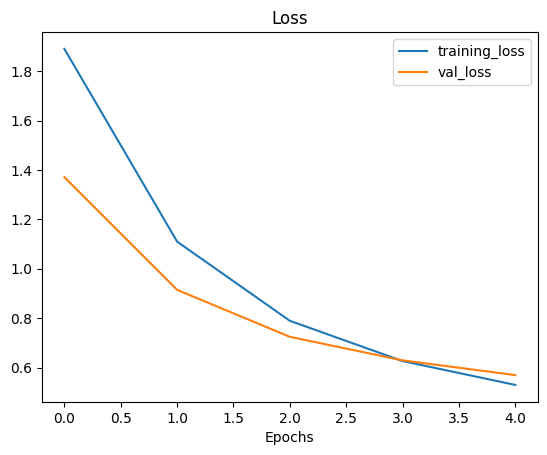

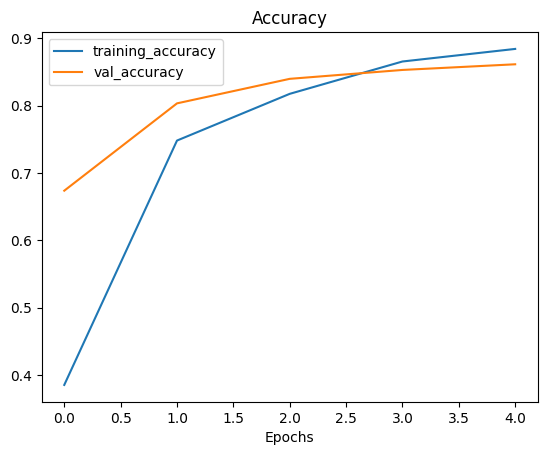

In [19]:
plot_loss_curves(efficientnet_history)

Qua quan sát loss curve của mô hình EfficientNetB0, có vẻ như nó sẽ cải thiện tốt hơn nếu chúng ta tiếp tục huấn luyện lâu hơn. Có lẽ các bạn sẽ muốn thử?

Hãy kiểm tra summary của mô hình.

In [20]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


Có vẻ như dù số lượng tham số ít hơn khoảng 4 lần (4,049,564 so với 23,564,800) so với ResNet50V2 extraction layer, EfficientNetB0 feature extraction layer vẫn đạt được chất lượng tốt hơn. Giờ chúng ta đã rõ "efficient" có nguồn gốc từ đâu.